In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
datadir = "/content/gdrive/MyDrive/CS5806 - Project" # path to the homework
if not os.path.exists(datadir):
  !ln -s "/content/gdrive/MyDrive/CS5806 - Project" $datadir # path to the homework
os.chdir(datadir)
!ls

'CS 5806 - Project.ipynb'   facebook_combined.txt.gz   facebook.tar.gz


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
from gensim.models import Word2Vec
import random

%matplotlib inline

In [ ]:
facebook = pd.read_csv(
    "facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook

,start_node,end_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
88229,4026,4030
88230,4027,4031
88231,4027,4032
88232,4027,4038


In [ ]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

In [ ]:
def generate_node_data(G):
  """
  Generates a dictionary containing data for each node in the graph G.

  Args:
      G: A networkx graph object representing the Facebook network.

  Returns:
      A dictionary where keys are node IDs and values are dictionaries with the following keys:
          - Id: The node number (same as the key)
          - Friends: A list of IDs of nodes connected to this node by a direct edge
          - GroupId: The group number assigned based on friend connections to spotlight nodes

  """
  node_data = {}
  spotlight_nodes = [0, 107, 348, 414, 686, 698, 1684, 1912, 3437, 3980]  # Assuming these are spotlight nodes
  shortest_paths = dict(nx.all_pairs_shortest_path_length(G))  # Pre-compute all shortest paths

  # Iterate over all nodes in the graph
  for node_id in G.nodes():
    node_data[node_id] = {
        "Id": node_id,
        "Friends": list(G.neighbors(node_id)),
        "GroupId": None
    }

  # Assign group IDs based on friend connections or shortest paths
  for spotlight_node in spotlight_nodes:
    spotlight_friends = set(G.neighbors(spotlight_node))
    for node_id, node_info in node_data.items():
      if not node_info["GroupId"]:
        # Check for friend connection
        if spotlight_node in node_info["Friends"]:
          node_info["GroupId"] = spotlight_node
        else:
          # Fallback: Use shortest path if no friend connection
          shortest_path_length = shortest_paths[node_id].get(spotlight_node)
          if shortest_path_length is not None:
            # Check for existing group or ties
            current_group = node_info["GroupId"]
            current_path_length = node_info.get("PathLength", float('inf'))  # Default to infinity for no previous path
            if not current_group or shortest_path_length < current_path_length:
              # Assign group or update if shorter path
              node_info["GroupId"] = spotlight_node
              node_info["PathLength"] = shortest_path_length
            elif shortest_path_length == current_path_length:
              # Handle ties: count shortest paths to each group with the same length
              group_path_counts = node_info.get("GroupPathCounts", defaultdict(int))
              group_path_counts[current_group] += 1
              group_path_counts[spotlight_node] += 1
              # Recalculate group based on most paths after tie check
              node_info["GroupId"] = max(group_path_counts, key=group_path_counts.get)

  return node_data

# Assuming you have already loaded the Facebook network data into a graph object 'G'
node_data = generate_node_data(G)

# Access data for a specific node (example)
node_id = 123  # Replace with the desired node ID
print(f"Node ID: {node_data[node_id]['Id']}")
print(f"Friends: {node_data[node_id]['Friends']}")
print(f"Group ID: {node_data[node_id]['GroupId']}")

Node ID: 123
Friends: [0, 21, 26, 55, 67, 82, 98, 104, 122, 142, 186, 200, 239, 252, 261, 318, 334, 342]
Group ID: 107


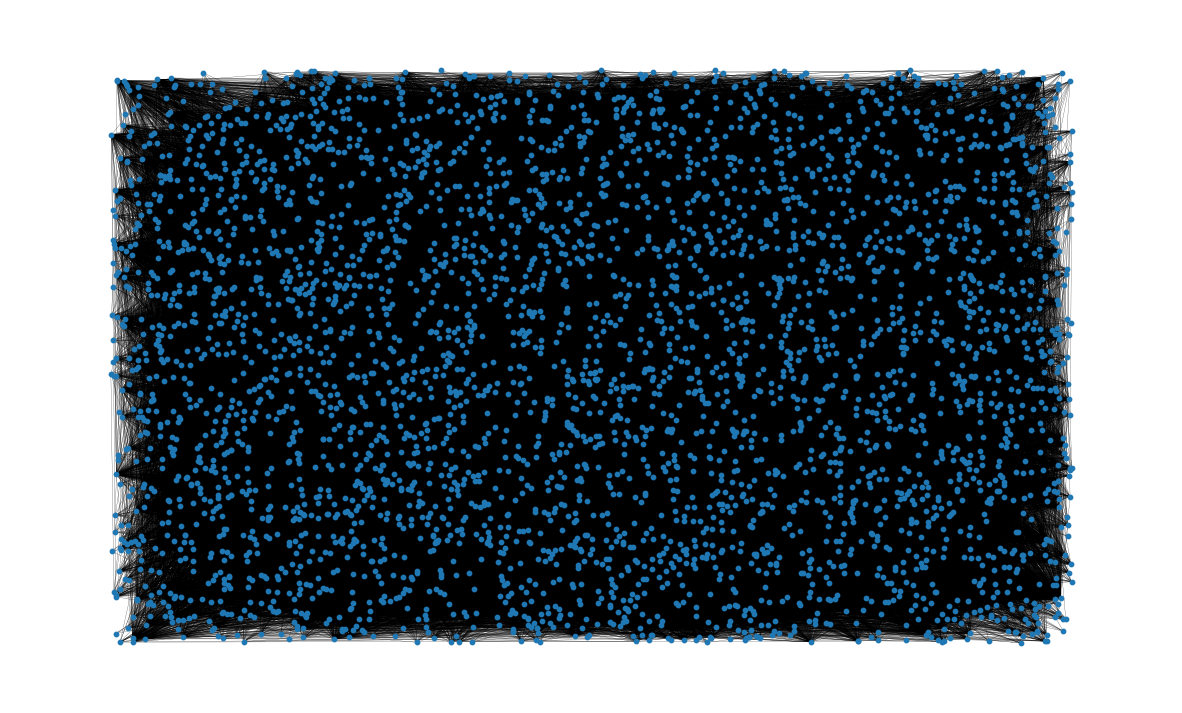

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

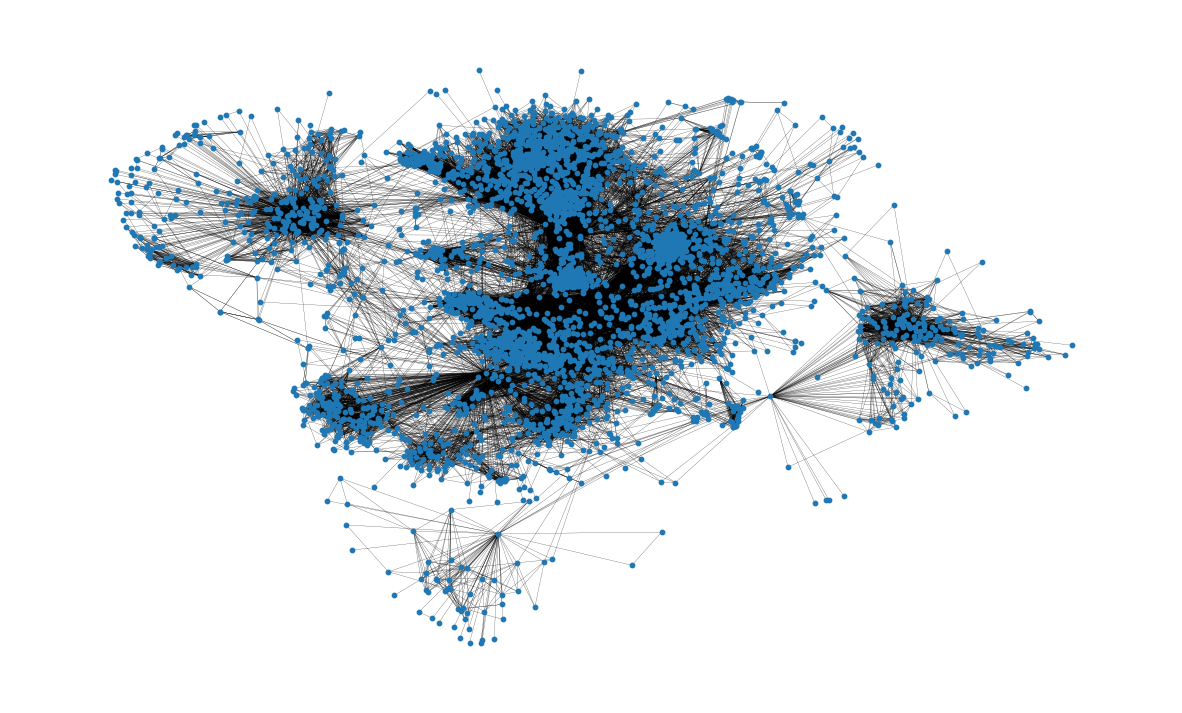

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
print("Number of nodes = ", G.number_of_nodes())
print("Number of edges = ", G.number_of_edges())
print("The average degree of a node = ", np.mean([d for _, d in G.degree()]))
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))
print("The shortest path from node 0 to node 42 = " , shortest_path_lengths[0][42])  # Length of shortest path between nodes 0 and 42
#Diameter
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
print("The diamater = ", diameter)
print("The density of the graph = ", nx.density(G))
print("The number of connected components = ", nx.number_connected_components(G))
print("The average clustering coefficient = ", nx.average_clustering(G))
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
print("The average path length = ", np.mean(average_path_lengths))

Number of nodes =  4039
Number of edges =  88234
The average degree of a node =  43.69101262688784
The shortest path from node 0 to node 42 =  1
The diamater =  8
The density of the graph =  0.010819963503439287
The number of connected components =  1
The average clustering coefficient =  0.6055467186200876
The average path length =  3.691592636562027


Text(0, 0.5, 'Frequency (%)')

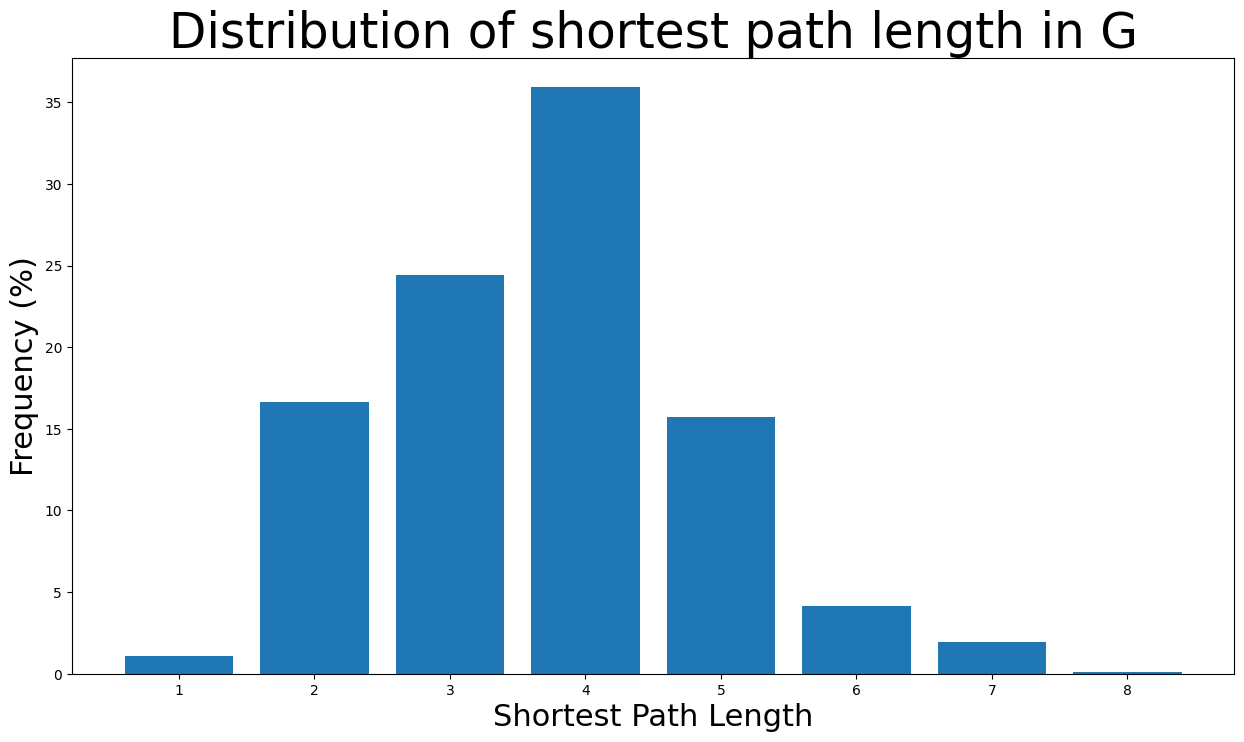

In [ ]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

In [ ]:
#These cells especially for class project
def find_top_nodes_by_degree(graph, top_n=8):
    # Get degree centrality for all nodes
    degree_centrality = nx.degree_centrality(graph)

    # Find the top nodes with the highest degree centrality
    top_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]
    return top_nodes

top_nodes = find_top_nodes_by_degree(G, top_n=8)
print("Top nodes by degree centrality:", top_nodes)

Top nodes by degree centrality: [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317)]


In [ ]:
def average_path_length_to_leaf_nodes(graph, top_nodes):
    # Identify all leaf nodes (nodes with degree 1)
    leaf_nodes = [node for node in graph.nodes() if graph.degree(node) == 1]

    # Dictionary to hold average path lengths
    average_lengths = {}

    # Calculate average path length from top nodes to leaf nodes
    for root, _ in top_nodes:
        lengths = []
        for leaf in leaf_nodes:
            if nx.has_path(graph, root, leaf):
                path_length = nx.shortest_path_length(graph, source=root, target=leaf)
                lengths.append(path_length)

        # Compute average if there are lengths to average
        if lengths:
            average_length = np.mean(lengths)
            average_lengths[root] = average_length
        else:
            average_lengths[root] = float('inf')  # Infinity if no paths to any leaf node

    return average_lengths

# Calculate the average path lengths for the top nodes
average_lengths = average_path_length_to_leaf_nodes(G, top_nodes)
print("Average path lengths from top nodes to leaf nodes:", average_lengths, len(average_lengths))

Average path lengths from top nodes to leaf nodes: {107: 2.493333333333333, 1684: 3.1066666666666665, 1912: 3.2666666666666666, 3437: 3.1333333333333333, 0: 3.026666666666667, 2543: 3.933333333333333, 2347: 4.12, 1888: 3.493333333333333} 8


In [ ]:
#following cell is for machine learning proejct
def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, start_node=node, length=walk_length))
    return walks

In [ ]:
def random_walk(graph, start_node, length):
    walk = [start_node]
    while len(walk) < length:
        cur = walk[-1]
        neighbors = list(graph.neighbors(cur))
        if not neighbors:
            break
        walk.append(random.choice(neighbors))
    return walk

In [ ]:
#following cell is for machine learning project
def create_training_pairs(walks, window_size):
    pairs = []
    for walk in walks:
        for i in range(len(walk)):
            for j in range(max(0, i - window_size), min(len(walk), i + window_size + 1)):
                if i != j:
                    pairs.append((walk[i], walk[j]))
    return pairs

In [ ]:
#following cell is for machine learning project
def train_skip_gram(pairs):
    # Preparing the format for Word2Vec training
    training_data = []
    for pair in pairs:
        training_data.append([pair[0], pair[1]])

    # Train a Word2Vec model
    model = Word2Vec(sentences=training_data, vector_size=64, window=10, min_count=0, sg=1, workers=4)
    return model

average_lengths = average_path_length_to_leaf_nodes(G, top_nodes)  # Use the average path length as context window size
walk_length=int(np.mean(list(average_lengths.values())))
print(walk_length)
walks = generate_random_walks(G, num_walks=10, walk_length=int(np.mean(list(average_lengths.values()))))
training_pairs = create_training_pairs(walks, window_size=10)  # Context window size as the average path length

3


In [ ]:
#following cell is for machine learning project
def deepwalk(graph, num_walks, walk_length, window_size, vector_size):
    walks = []
    for _ in range(num_walks):
        nodes = list(graph.nodes())
        random.shuffle(nodes)
        for node in nodes:
            walks.append(random_walk(graph, start_node=node, length=walk_length))

    # Prepare walks for Word2Vec
    walks = [[str(node) for node in walk] for walk in walks]  # Convert all nodes to string
    model = Word2Vec(walks, vector_size=vector_size, window=window_size, min_count=0, sg=1, workers=4)
    return model

# Assuming 'graph' is already defined
standard_model = deepwalk(G, num_walks=10, walk_length=80, window_size=10, vector_size=64)
modified_model = train_skip_gram(training_pairs)  # from previous custom DeepWalk setup

In [ ]:
print(standard_model.wv['0'].shape)
print(modified_model.wv[0].shape)

(64,)
(64,)


In [ ]:
features = []
group_ids = []
for node_id, node_info in node_data.items():
    id = str(node_id)  # Convert node identifier to string
    if node_id in modified_model.wv:  # Check if node has 'GroupId' and an embedding
      features.append(standard_model.wv[node_id])
      group_ids.append(node_info['GroupId'])

print(features[0])
print(group_ids[0])

[-0.39889145 -0.40629876  0.7383222   0.58107156  0.06180252 -0.6254791
  0.72901994  0.6889351   0.08760086  0.13048239  0.16843794 -0.2077186
  0.242412    0.19361654  0.23679402 -0.1449876  -0.67467064 -0.05445817
 -0.44188416 -0.11187537  0.9890123   0.27527887  0.55436057 -0.5535819
 -0.23516098  0.13455553  0.46126807  0.40820763 -0.08121865 -0.590707
  0.5780065   0.2749359   0.12584907 -0.26671967  0.08662292  0.36606228
  0.3359954   0.24194077 -0.01101466 -0.26562825 -0.07312155  0.69800985
 -0.65629303 -0.1635053   0.24113487  0.22160348  0.20636903  0.41564316
  0.2124626  -0.14947379 -0.26503143  0.7804697  -0.3698198   0.4422787
  0.6409818  -0.7553655  -0.14120415 -0.25690567 -0.38391048 -0.05682031
  0.05266269  0.12667473  0.34617016 -0.92166597]
107


In [ ]:
def get_features_labels(graph, model):
  """
  Extracts node features (embeddings) and corresponding group IDs from the graph and model.

  Args:
      graph: A networkx graph object.
      model: A word2vec model containing node embeddings.

  Returns:
      A tuple containing two lists:
          - features: A list of node embeddings.
          - group_ids: A list of group IDs corresponding to each node in the features list.
  """
  features = []
  group_ids = []

  # Iterate over nodes using list comprehension for safety
  for node_id, node_info in node_data.items():
    id = str(node_id)  # Convert node identifier to string
    if id in model.wv:  # Check if node has 'GroupId' and an embedding
      features.append(model.wv[node_id])
      group_ids.append(node_info['GroupId'])

  if not features or not group_ids:  # Check if any features or group IDs are collected
    print("No features or group IDs available. Check node data and model embeddings.")

  return features, group_ids

In [ ]:
def evaluate_embeddings(graph, model):
  """
  Evaluates the quality of node embeddings for a classification task.

  Args:
      graph: A networkx graph object.
      model: A word2vec model containing node embeddings.

  Prints classification evaluation metrics like accuracy, confusion matrix, and ROC-AUC (if binary).

  Returns:
      Accuracy score (or any other chosen metric).
  """
  X, y = get_features_labels(graph, model)
  if not X or not y:  # Check if X or y are empty
    print("Insufficient data for training. Exiting evaluation.")
    return

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

  # Train a logistic regression classifier
  clf = LogisticRegression(random_state=0)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

  # Classification report
  print(classification_report(y_test, y_pred))

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Labels')
  plt.xlabel('Predicted Labels')
  plt.show()

  # ROC and AUC (only if binary classification)
  if len(set(y)) == 2:  # Check if the task is binary
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Example Classifier').plot()
    plt.show()

  return accuracy  # Return accuracy or any other metric as per need

# Example of usage (assuming 'graph' and 'model' are already defined)
evaluate_embeddings(G, standard_model)
evaluate_embeddings(G, modified_model)

# Following cell is for a machine learning project
standard_accuracy = evaluate_embeddings(G, standard_model)
modified_accuracy = evaluate_embeddings(G, modified_model)

No features or group IDs available. Check node data and model embeddings.
Insufficient data for training. Exiting evaluation.
No features or group IDs available. Check node data and model embeddings.
Insufficient data for training. Exiting evaluation.
No features or group IDs available. Check node data and model embeddings.
Insufficient data for training. Exiting evaluation.
No features or group IDs available. Check node data and model embeddings.
Insufficient data for training. Exiting evaluation.
